In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

In [29]:
# influence of broken rate on theo central model

# integrated server ruuning version
# with multiprocessing
# central with broken

# Solution
# We set the N to be 100
# broken rate in range(0.01, 0.99, 0.01)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
import time

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'gamma' : 10.0,
        'c_server' : 1,
        'phi' : 10.0,
        'f_server' : 1,
        'delta' : 10.0,
        'd_server' : 1,
        'broken' : 0,
        'sv' : 0, # standard variance
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# theoretical QN
# simulate situation with collect, fix and redistribute
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    
    # initiate the parameters in this function
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.C = [] # time to be empty for collecting queue
        self.F = [] # time to be empty for fixing queue
        self.D = [] # time to be empty for distributing queue
        [heapq.heapify(_) for _ in [self.C, self.F, self.D]]
        # states: devide into 2 parts
        # A0, ... AA, C, F, D: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        # self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+3) # initiate the state list
        self.state1 = [int(self.N/self.A)]*self.A + [0]*3 # the last 3 numbers are for C, F, and D
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate four events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        return self.state1, self.state2, self.T

    def simulate(self, writefile, start):
        if writefile:
            with open(RESULT_ADD+str(start)+'central_broken.csv', 'a') as fout:
                writer = csv.writer(fout)
                #writer.writerow(self.R)
                #writer.writerow(self.R.values())
                #writer.writerow(self.reset())
                self.reset()
                while self.T <= self.time_limit:
                    self.step()
                writer.writerow([self.R['broken'], self.served_customers / (self.T-self.warmup_time)])
        else:
            self.reset()
            while self.T <= self.time_limit:
                self.step()
            return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)

        
    def add_event(self, kind):
        if kind == 2: 
            next_time = random.expovariate(self.R['gamma'])
            next_time += self.T if self.state1[-3] <= self.R['c_server'] else heapq.heappop(self.C)
            heapq.heappush(self.C, next_time)
            start, end = 'c', 'f'
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[-2] <= self.R['f_server'] else heapq.heappop(self.F)
            heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        elif kind == 4: 
            next_time = random.expovariate(self.R['delta'])
            next_time += self.T if self.state1[-1] <= self.R['d_server'] else heapq.heappop(self.D)
            heapq.heappush(self.D, next_time)
            start, end = 'd', random.choice(list(range(self.A)))
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: a bike finishes at collecting queue
         3: a bike finishes at fixed queue
         4: a bike finishes at distributed queue
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[-3] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[-3] -= 1
            self.state1[-2] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-3] < self.R['c_server']: heapq.heappop(self.C)
            self.add_event(3)
        elif kind == 3:
            self.state1[-2] -= 1
            self.state1[-1] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-2] < self.R['f_server']: heapq.heappop(self.F)
            self.add_event(4)
        elif kind == 4:
            self.state1[-1] -= 1
            self.state1[terminal] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-1] < self.R['d_server']: heapq.heappop(self.D)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state1, self.state2, self.T

        
resultc0 = []
def run(start):

    env = BikeNet(N=N,
                  A=A,
                  R=R,
                  P=P,
                  warmup_time=WARMUP_TIME,
                  run_time=RUN_TIME)

    for b in tqdm(range(101)):
        env.R['broken'] = b*0.01
        resultc0.append(env.simulate(IF_WRITEFILE, start))
    #return result
    
# Hyper parameters
EPISODES = 50 # times every setting is replicated
#IF_WRITEFILE = True
IF_WRITEFILE = False
RESULT_ADD = '/Users/valarian/SJTU/SJTU/毕业论文/Data/result/data_仿真结果/central/' + 'central_no_broken_vary_lambda.csv'

WARMUP_TIME = 200
RUN_TIME = 1000
    
if __name__ == '__main__':

    
    run(0)
    

100%|██████████| 101/101 [00:50<00:00,  1.98it/s]


In [5]:
#real central
#按照capacity/A的数量放置好车
# initialize parameters
rate = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'gamma' : 1.0,
        'phi' : 5.0,
        'delta' : 1.0,
        'broken' : 0.3,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# real
# the influence of phi
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.C = 0
        self.F = 0
        #self.D = 0
        self.capacity = 12
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0
#         self.C = 0
        self.F = 0
#         self.D = 0
        self.served_customers = 0
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, [normal, broken, time]]
        heapq.heappush(self.scheduler, [0, 0, 0, [0,0,self.T+self.R['period']]])
        return self.state + [self.T]

    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/central/data/central_broken_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)
                
    def get_index(self, target):
        if target == 'c': return 4
        elif target == 'f': return 5
        elif target == 'd': return 6
        else:
            s, t = int(target[0]), int(target[1])
            return 2*self.A + 2 + 4*s + t
        
    def add_event(self, kind, s):
        if kind == 2:
            next_time = random.expovariate(self.R['gamma']) + self.T
            start, end = s, 'f'
        elif kind == 3:
            next_time = random.expovariate(self.R['phi']) + max(self.T, self.F)
            self.F, start, end = next_time, 'f', 'd'
        elif kind == 0:
            next_time = random.expovariate(self.R['delta']) + self.T
            start, end = random.choice(list(range(self.A))), [s, 0, self.T+self.R['period']]
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: carrier arrives as a area
         1: a bike arrives
         2: carrier full of broken bikes arrives as the repairing center
         3: a bike was fixed
        '''
        if kind == 0: #carrier 正在areas之间逡巡中，鱼戏莲叶南，鱼戏莲叶北
            normal, broken, end_time = terminal[0], terminal[1], terminal[2]
            if normal > 0: #如果有好车，先把好车放下
                #print(self.scheduler[0])
                #print('holla', normal, broken)
                number = min(normal, int(self.capacity/self.A))
                self.state[start] += number
                self.scheduler[0][3][0] -= number
                normal -= number
                #print(self.scheduler[0])
                #print(self.state, '\n')
            if self.state[self.A+start]>0 and broken+normal < self.capacity: #如果有坏车，并且运载车没满，把坏车装上运载车
                number = min(self.capacity - broken-normal, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
            if broken == self.capacity or (self.T>end_time and normal==0):
                heapq.heappop(self.scheduler)
                self.add_event(2, broken)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (start+1)%4
                heapq.heapify(self.scheduler) 
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[self.A+terminal] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            if self.state[self.A * 2 + 1]==0:
                self.add_event(3, start)
            self.state[self.A * 2 + 1] += start
            heapq.heappop(self.scheduler)
            number = min(self.capacity, self.state[self.A * 2])
            self.add_event(0, number)
            self.state[self.A * 2] -= number
        elif kind == 3:
            #print(self.state)
            self.state[self.A * 2] += 1
            self.state[self.A * 2 + 1] -= 1
            heapq.heappop(self.scheduler)
            if self.state[self.A * 2 + 1] > 0:
                self.add_event(3, start)
                #print('next fix')
            #print(self.state)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>self.warmup_time: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(int(target[0]), int(target[1])) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

#random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 200
run_time = 1000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)

resultc0 = []
env.R['car_move'] = 0.1
#for j in tqdm(range(1,20)):
#    env.R['gamma'] = 0.5 + j*0.5
#for i in tqdm(range(101)):
for i in range(101):
    env.R['broken'] = i*0.01
    resultc0.append(env.simulate())
    


In [40]:
#real central
#把所有区域的好车数量往N/A调整
#在这种情况下可能存在的一种情况是，因为
# initialize parameters


rate = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'capacity': 12,
        'gamma' : 1.0,
        'phi' : 1.0,
        'delta' : 1.0,
        'broken' : 0.3,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# real
# the influence of phi
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.C = 0
        self.F = 0
        #self.D = 0
        self.capacity = self.R['capacity']
        self.areas = list(range(A))

        self.served_customers = 0
        self.target_number = int(self.N/self.A)
        
    def reset(self):
        self.T = 0
#         self.C = 0
        self.F = 0
#         self.D = 0
        self.served_customers = 0
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, [normal, broken, time]]
        heapq.heappush(self.scheduler, [0, 0, 0, [0,0,self.T+self.R['period']]])
        #return self.state + [self.T]

    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/central/data/central_broken_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)
                
    def get_index(self, target):
        if target == 'c': return 4
        elif target == 'f': return 5
        elif target == 'd': return 6
        else:
            s, t = int(target[0]), int(target[1])
            return 2*self.A + 2 + 4*s + t
        
    def add_event(self, kind, s):
        if kind == 2:
            next_time = random.expovariate(self.R['gamma']) + self.T
            start, end = s, 'f'
        elif kind == 3:
            next_time = random.expovariate(self.R['phi']) + max(self.T, self.F)
            self.F, start, end = next_time, 'f', 'd'
        elif kind == 0:
            next_time = random.expovariate(self.R['delta']) + self.T
            start, end = random.choice(list(range(self.A))), [s, 0, self.T+self.R['period']]
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: carrier arrives as a area
         1: a bike arrives
         2: carrier full of broken bikes arrives as the repairing center
         3: a bike was fixed
        '''
        if kind == 0: #carrier 正在areas之间逡巡中，鱼戏莲叶南，鱼戏莲叶北
            '''
            处理的顺序为：
            1、如果当前区域好车数不到target_number，则将好车放下，之后pick up坏车
            2、如果超过目标值，优先将坏车pick up，剩余的位置pick up好车
            '''
            normal, broken, end_time = terminal[0], terminal[1], terminal[2]
            d = self.target_number-self.state[start]
            if d>0:
                #drop down broken bikes
                number = min(normal, d)
                self.state[start] += number
                self.scheduler[0][3][0] -= number
                normal -= number
                #pick up normal bikes
                number = min(self.capacity - broken-normal, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
            elif d<0:
                #pick up broken bikes
                number = min(self.capacity - broken-normal, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
                #drop down normal bikes
                if self.capacity > normal+broken:
                    number = min(self.state[start] - self.target_number, self.capacity-normal-broken)
                    self.state[start] -= number
                    self.scheduler[0][3][0] += number
                    normal += number
            if broken == self.capacity or (self.T>end_time and normal==0):
                #print('carrier goes back')
                heapq.heappop(self.scheduler)
                self.add_event(2, broken)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (start+1)%4
                heapq.heapify(self.scheduler) 
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[self.A+terminal] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            if self.state[self.A * 2 + 1]==0:
                self.add_event(3, start)
            self.state[self.A * 2 + 1] += start
            heapq.heappop(self.scheduler)
            number = min(self.capacity, self.state[self.A * 2])
            self.add_event(0, number)
            self.state[self.A * 2] -= number
        elif kind == 3:
            #print(self.state)
            self.state[self.A * 2] += 1
            self.state[self.A * 2 + 1] -= 1
            heapq.heappop(self.scheduler)
            if self.state[self.A * 2 + 1] > 0:
                self.add_event(3, start)
                #print('next fix')
            #print(self.state)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>self.warmup_time: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(int(target[0]), int(target[1])) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 2000
run_time = 5000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
env.R['car_move'] = 2
resultc1 = []
#for j in tqdm(range(1,20)):
#    env.R['gamma'] = 0.5 + j*0.5
for i in tqdm(range(101)):
    env.R['broken'] = i*0.01
    resultc1.append(env.simulate())
    


100%|██████████| 101/101 [04:06<00:00,  2.44s/it]


In [10]:
#central
#把所有区域的好车数量往N/A调整
#在这种情况下可能存在的一种情况是，因为
# initialize parameters


rate = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'capacity': 12,
        'gamma' : 1.0,
        'phi' : 1.0,
        'delta' : 1.0,
        'broken' : 0.3,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# real
# the influence of phi
# in this version, carrier moves among areas to collect broken bikes
# then brings them to the repair center, and bring the normal bikes back to areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.C = 0
        self.F = 0
        #self.D = 0
        self.capacity = self.R['capacity']
        self.areas = list(range(A))

        self.served_customers = 0
        self.target_number = int(self.N/self.A)
        
    def reset(self):
        self.T = 0
#         self.C = 0
        self.F = 0
#         self.D = 0
        self.served_customers = 0
        #queues: A0, A1, B0, B1, FN, FB, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2+self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, [normal, broken, time]]
        heapq.heappush(self.scheduler, [0, 0, 0, [0,0,self.T+self.R['period']]])
        #return self.state + [self.T]

    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/central/data/central_broken_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: return 2.0
        else: r = 1.0
        return random.expovariate(r)
                
    def get_index(self, target):
        if target == 'c': return 4
        elif target == 'f': return 5
        elif target == 'd': return 6
        else:
            s, t = int(target[0]), int(target[1])
            return 2*self.A + 2 + 4*s + t
        
    def add_event(self, kind, s):
        if kind == 2:
            next_time = random.expovariate(self.R['gamma']) + self.T
            start, end = s, 'f'
        elif kind == 3:
            next_time = random.expovariate(self.R['phi']) + max(self.T, self.F)
            self.F, start, end = next_time, 'f', 'd'
        elif kind == 0:
            next_time = random.expovariate(self.R['delta']) + self.T
            start, end = random.choice(list(range(self.A))), [s, 0, self.T+self.R['period']]
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: carrier arrives as a area
         1: a bike arrives
         2: carrier full of broken bikes arrives as the repairing center
         3: a bike was fixed
        '''
        if kind == 0: #carrier 正在areas之间逡巡中，鱼戏莲叶南，鱼戏莲叶北
            '''
            处理的顺序为：
            1、如果当前区域好车数不到target_number，则将好车放下，之后pick up坏车
            2、如果超过目标值，优先将坏车pick up，剩余的位置pick up好车
            '''
            normal, broken, end_time = terminal[0], terminal[1], terminal[2]
            d = self.target_number-self.state[start]
            if d>0:
                #drop down broken bikes
                number = min(normal, d)
                self.state[start] += number
                self.scheduler[0][3][0] -= number
                normal -= number
                #pick up normal bikes
                number = min(self.capacity - broken-normal, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
            elif d<0:
                #pick up broken bikes
                number = min(self.capacity - broken-normal, self.state[self.A + start])
                self.state[self.A+start] -= number
                self.scheduler[0][3][1] += number
                broken += number
                #drop down normal bikes
                if self.capacity > normal+broken:
                    number = min(self.state[start] - self.target_number, self.capacity-normal-broken)
                    self.state[start] -= number
                    self.scheduler[0][3][0] += number
                    normal += number
            if broken == self.capacity:
                #print('carrier goes back')
                heapq.heappop(self.scheduler)
                self.add_event(2, broken)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (start+1)%4
                heapq.heapify(self.scheduler) 
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[self.A+terminal] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            if self.state[self.A * 2 + 1]==0:
                self.add_event(3, start)
            self.state[self.A * 2 + 1] += start
            heapq.heappop(self.scheduler)
            number = min(self.capacity, self.state[self.A * 2])
            self.add_event(0, number)
            self.state[self.A * 2] -= number
        elif kind == 3:
            #print(self.state)
            self.state[self.A * 2] += 1
            self.state[self.A * 2 + 1] -= 1
            heapq.heappop(self.scheduler)
            if self.state[self.A * 2 + 1] > 0:
                self.add_event(3, start)
                #print('next fix')
            #print(self.state)
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>self.warmup_time: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(int(target[0]), int(target[1])) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 500
run_time = 1000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
env.R['gamma'] = 10
env.R['phi'] = 10
resultc2 = []
#for j in tqdm(range(1,20)):
#    env.R['gamma'] = 0.5 + j*0.5
for i in tqdm(range(101)):
    env.R['broken'] = i*0.01
    resultc2.append(env.simulate())
    
# 看看如果没有time period，只有当坏车装满才回去的结果

100%|██████████| 101/101 [01:57<00:00,  1.17s/it]


# real broken rate, the distributed doesn't redistribute

In [26]:
#distributed

# initialize parameters
rate = {'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,
        'broken' : 0.3,
        'phi' : 1.0,
        'car_move' : 1.0,
        #'delta' : 1.0,
       }
#broken = 0.2
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

#real
#the influence of phi
#the collection is no longer a queue
#but a car moving among areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        #self.capacity = 10
        #self.W = [0]*4
        self.F = 0
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))
        self.served_customers = 0

#         self.reset()

    def reset(self):
        self.T = 0
        self.served_customers = 0
        #self.W = [0]*4
        #self.F = [0]*4
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, dummy parameter]
        heapq.heappush(self.scheduler, [0, 0, 0, 0])
        return self.state + [self.T]

    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/distributed/data/distributed_carmove_0.5_0.5_20_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
        return self.served_customers / (self.T-self.warmup_time)
        
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A*3 + self.A*s + t
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t, t])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0:
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
                heapq.heappop(self.scheduler)
            else:
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.state[int(start[1])+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state[self.A*2+terminal] -= 1
            self.state[terminal] += 1
            heapq.heappop(self.scheduler)
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, start)
            else:
                event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, 0]
                heapq.heappush(self.scheduler, event) 
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>self.warmup_time: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(int(target[0]), int(target[1])) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 2000
run_time = 5000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
env.R['car_move'] = 0.1
resultd0 = []
#for j in tqdm(range(1,20)):
#    env.R['gamma'] = 0.5 + j*0.5
for i in tqdm(range(101)):
    env.R['broken'] = i*0.01
    resultd0.append(env.simulate())
    


100%|██████████| 101/101 [04:15<00:00,  2.53s/it]


# real broken rate, the distributed does redistribute

In [2]:
#distributed model with carrier repairing onsite and rebalance bikes at the same time

# initialize parameters
rate = {'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'omega' : 1.0,
        'broken' : 0.3,
        'phi' : 5.0,
        'car_move' : 1.0,
        'capacity' : 12,
        #'delta' : 1.0,
       }
#broken = 0.2
#queues: A0, A1, C, F, D, R00, R01, R10, R11
pij = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

#real
#the influence of phi
#the collection is no longer a queue
#but a car moving among areas
class BikeNet():
    def __init__(self, N, A, R, P, warmup_time, run_time):
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.capacity = self.R['capacity']
        #self.W = [0]*4
        self.F = 0
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))
        self.served_customers = 0
        
        self.target_number = self.N/self.A
        self.b, self.n = 0, 0

#         self.reset()

    def reset(self):
        self.T = 0
        self.served_customers = 0
        #self.W = [0]*4
        #self.F = [0]*4
        #queues: A0, A1, C, F, D, R00, R01, R10, R11
        self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+2*self.A+1)
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #event of the carrier, [time, kind, place, dummy parameter]
        heapq.heappush(self.scheduler, [0, 0, 0, 0])
        return self.state + [self.T]

    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/distributed/data/distributed_carmove_0.5_0.5_20_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
            #print(self.state)
        return self.served_customers / (self.T-self.warmup_time)
        
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |3|2|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)
                
    def get_index(self, target):
        if target == 'c': return self.A
        elif target == 'f': return self.A+1
        elif target == 'd': return self.A+2
        else:
            s, t = int(target[0]), int(target[1])
            return self.A*3 + self.A*s + t
        
    def add_event(self, kind, t):
        #self.F[t], start, end = next_time, t, t
        next_time = random.expovariate(self.R['phi']) + self.T
        #if self.state[self.A+t] == 0: self.scheduler[0][2] = (self.scheduler[0][2]+1)%4
        #the state of carrier, [time, kind, position, number of bikes carrying]
        heapq.heappush(self.scheduler, [next_time, kind, t[0], t[1]])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''kind:
        -1: customer ride a bike away
         0: the carrier moving
         1: a bike arrives
         2: a bike was fixed
        '''
        if kind == 0: # carrirer arriving at some area
            normal = self.scheduler[0][3] #当前载有多少好车
            if self.state[start+self.A]>0: #如果有坏车
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, [start, normal])
            else:                          #如果没有坏车
                d = self.state[start] - self.target_number
                #redistribute the normal bikes
                if d > 0: #该区域好车多于标准值
                    number = min(self.capacity-normal, d)
                    self.scheduler[0][3] += number
                    self.state[-1] += number
                    self.state[start] -= number
                elif d<0: #该区域好车少于标准值
                    number = min(-d, normal)
                    self.scheduler[0][3] -= number
                    self.state[-1] -= number
                    self.state[start] += number
                self.scheduler[0][0] += random.expovariate(self.R['car_move'])
                self.scheduler[0][2] = (self.scheduler[0][2]+1)%self.A
                heapq.heapify(self.scheduler)                                                        
        elif kind == 1: # 顾客骑行到达
            self.state[self.get_index(start)] -= 1
            if random.random()<self.R['broken']:
                self.b+=1
                #print('here\'s a broken %d'%(self.b))
                self.state[terminal+self.A] += 1
                heapq.heappop(self.scheduler)
            else:
                #print(self.scheduler[0])
                self.n += 1
                self.state[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            #print(self.T, 'execute 2')
            self.state[self.A*2+start] -= 1
            self.state[start] += 1
            heapq.heappop(self.scheduler)
            if self.state[start+self.A]>0:
                self.state[start+self.A] -= 1
                self.state[self.A*2 + start] += 1
                self.add_event(2, [start, terminal])
            else:
                d = self.state[start] - self.target_number
                if d > 0: #redistribute the normal bikes
                    number = min(self.capacity-terminal, d)
                    self.state[start] -= number
                    self.state[-1] = number+terminal
                    event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, number+terminal]
                    heapq.heappush(self.scheduler, event)
                elif d<0:
                    number = min(-d, terminal)
                    self.state[start] += number
                    self.state[-1] = terminal-number
                    event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, terminal-number]
                    heapq.heappush(self.scheduler, event) 
                else:
                    event = [self.T+random.expovariate(self.R['car_move']), 0, (start+1)%4, terminal]
                    heapq.heappush(self.scheduler, event) 
        else:# 顾客到达
            if self.state[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                target = str(start)+ str(np.random.choice(self.areas, 1, p=self.P[start])[0])
                if self.T>self.warmup_time: self.served_customers += 1
                self.state[start] -= 1
                self.state[self.get_index(target)] += 1
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(int(target[0]), int(target[1])) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, target, int(target[1])])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        return self.state+[self.T]

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = rate
P = pij

warmup_time = 200
run_time = 1000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
env.R['car_move'] = 2
resultd1 = []
# env.R['broken'] = 0.01
# resultd1.append(env.simulate())
# print(resultd1)

for i in tqdm(range(101)):
    env.R['broken'] = i*0.01
    resultd1.append(env.simulate())
    
# for i in tqdm(range(21)):
#     env.R['broken'] = i*0.05
#     resultd1.append(env.simulate())
#     print(resultd1)

100%|██████████| 101/101 [01:35<00:00,  1.05it/s]


In [30]:
# 单一等待队列和单一维修队列，没有redistribute的distribute的theoretical
# integrated server ruuning version
# with multiprocessing
# central no broken same lambda


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm

from multiprocessing import Pool


N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space


# initialize parameters
R = {
        'lambda0' : 20.0,
        'lambda1' : 20.0,
        'lambda2' : 20.0,
        'lambda3' : 20.0,
        'car_move': 1.0,
        'omega' : 10.0,
        'w_server' : 1,
        'phi' : 10.0,
        'f_server' : 1,
        'broken' : 0,
        'period' : 90, #the maximal time for a carrier to move among areas
       }
#queues: A0, A1, C, F, D, R00, R01, R10, R11
P = [
        [0.1, 0.4, 0.4, 0.1], 
        [0.4, 0.1, 0.1, 0.4], 
        [0.4, 0.1, 0.1, 0.4],
        [0.1, 0.4, 0.4, 0.1],
      ]

# theoretical QN
# simulate situation with collect, fix and redistribute
# in this version, bikes found broken after a customer RIDING


# BikeNet is the class for simulate the CQN
# simulate by discrete event, in this program called a step
# the average customer served on time is out research object

class BikeNet():
    
    # initiate the parameters in this function
    def __init__(self, N, A, R, P, warmup_time, run_time):
        '''
        N: number of bikes in the CQN
        A: number of areas in the CQN
        R: rates of the system
        P: matrix of transit probability, including to broken
        warmup_time: the time to warm up the system
        run_time: the period of time during which get the performance
        '''
        
        self.N = N
        self.A = A
        self.R = R
        self.P = P
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
#         self.edge = int(self.A**0.5)
        self.areas = list(range(A))

        self.served_customers = 0

    def reset(self):
        self.T = 0 # time cursor to indicate the system time in this episode, at the end of every episode should be default to zero
        self.served_customers = 0 # the performance indicator
        self.W = [] # time to be empty for collecting queue
        self.F = [] # time to be empty for fixing queue
        [heapq.heapify(_) for _ in [self.W, self.F]]
        # states: devide into 2 parts
        # A0, ... AA, W, F: 1-d list
        # [[R00, ..., R(0,A-1)1], ..., [R(A-1,0), ..., R(A-1,A-1)]]: 2-d list for all riding queues
        # self.state = [int(self.N/self.A)]*self.A + [0]*(self.A**2+3) # initiate the state list
        self.state1 = [int(self.N/self.A)]*self.A + [0]*2 # the last 3 numbers are for C, F, and D
        self.state2 = [[0]*self.A for i in range(self.A)]
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            # state: [time, type, start, terminal]
            # initially generate four events of arriving at each area
            heapq.heappush(self.scheduler, [random.expovariate(self.R['lambda'+str(i)]), -1, i, 0])
        #return self.state1, self.state2, self.T


    def simulate(self):
#         with open('C:/Rebalancing/data/simulationResult/distributed/data/distributed_carmove_0.5_0.5_20_real.csv', 'w') as fout:
#             writer = csv.writer(fout)
#             writer.writerow(self.R)
#             writer.writerow(self.R.values())
#             writer.writerow(self.reset())
#             while self.T <= self.time_limit:
#                 writer.writerow(self.step())
#         return self.served_customers / (self.T-10000)
        self.reset()
        while self.T <= self.time_limit:
            self.step()
            #print(self.state)
        return self.served_customers / (self.T-self.warmup_time)
                
    def get_riding_time(self, s, t):
        '''
        |0|1|
        |2|3|
        '''
        if s==t: r = 0.5
        elif abs(s-t) == 2: r = 2.0
        else: r = 1.0
        return random.expovariate(r)

        
    def add_event(self, kind, para):
        if kind == 2: 
            next_time = random.expovariate(self.R['omega'])
            next_time += self.T if self.state1[-2] <= self.R['w_server'] else heapq.heappop(self.W)
            heapq.heappush(self.W, next_time)
            start, end = para, 'f'
        elif kind == 3: 
            next_time = random.expovariate(self.R['phi'])
            next_time += self.T if self.state1[-1] <= self.R['f_server'] else heapq.heappop(self.F)
            heapq.heappush(self.F, next_time)
            start, end = para, 'f'

        heapq.heappush(self.scheduler, [next_time, kind, start, end])
        
    
    def step(self):

        event = self.scheduler[0]
        self.T, kind, start, terminal = event[0], event[1], event[2], event[3]

        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: a bike finishes at waiting queue
         3: a bike finishes at fixed queue
         4: a bike finishes at distributed queue
        '''
        if kind == 1: # 顾客骑行到达
            self.state2[start][terminal] -= 1
            if random.random()<self.R['broken']:
                self.state1[-2] += 1
                heapq.heappop(self.scheduler)
                self.add_event(2, start)
            else:
                self.state1[terminal] += 1
                heapq.heappop(self.scheduler)
        elif kind == 2:
            self.state1[-2] -= 1
            self.state1[-1] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-2] < self.R['w_server']: heapq.heappop(self.W)
            self.add_event(3, start)
        elif kind == 3:
            self.state1[-1] -= 1
            self.state1[start] += 1
            heapq.heappop(self.scheduler)
            if self.state1[-1] < self.R['f_server']: heapq.heappop(self.F)
        else:# 顾客到达
            if self.state1[start] == 0:  # 但没车
                heapq.heappop(self.scheduler)
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])
            else:
                if self.T>self.warmup_time: 
                    self.served_customers += 1
                    #result.append(self.served_customers / (self.T-self.warmup_time))
                # if self.T>self.warmup_time: result.append(self.T)
                
                self.state1[start] -= 1
                target = random.choices(self.areas, weights=self.P[start], k=1)[0]
                self.state2[start][target] += 1
                
                heapq.heappop(self.scheduler)
                next_time = self.get_riding_time(start, target) + self.T
                heapq.heappush(self.scheduler, [next_time, 1, start, target])
                next_time = random.expovariate(self.R['lambda'+str(start)]) + self.T
                heapq.heappush(self.scheduler, [next_time, -1, start, 0])


        #return self.state1, self.state2, self.T

random.seed(1)
N = 100  # total number of bikes in the QN
A = 4  # A for areas, indicates the number of areas and the action space
R = R
P = P

warmup_time = 200
run_time = 1000

env = BikeNet(N=N,
              A=A,
              R=R,
              P=P,
              #repair=t_repair,
              warmup_time=warmup_time,
              run_time=run_time)
              #start_position=0)
    
#print(env.R)
resultd0 = []
# env.R['broken'] = 0.01
# resultd1.append(env.simulate())
# print(resultd1)

for i in tqdm(range(101)):
    env.R['broken'] = i*0.01
    resultd0.append(env.simulate())
    
# for i in tqdm(range(21)):
#     env.R['broken'] = i*0.05
#     resultd1.append(env.simulate())
#     print(resultd1)

100%|██████████| 101/101 [00:45<00:00,  2.22it/s]


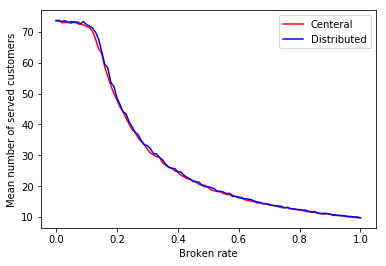

In [31]:
#x = np.arange(0, 1.01, 0.01)
x1 = np.arange(0, 1.01, 0.01)
plt.plot(x1,resultc0, c='r', label = 'Centeral')
#plt.plot(x1,resultc1, c='r', label = 'Centeral') #marker='o')
#plt.plot(x1,resultc2, c='r', label = 'Central')#, marker='o')
#plt.plot(x1,resultd1, c='b', label = 'Distributed') #marker='x')
#plt.plot(x1,resultd2, c='y', marker='x')
plt.plot(x1,resultd0, c='b', label = 'Distributed') #marker='x')
#plt.axis([0,21,0,35])
plt.xlabel('Broken rate')
plt.ylabel('Mean number of served customers')
plt.legend()
#plt.savefig('/Users/valarian/Desktop/article review/My paper/graph/theo_broken_rate.png', dpi=300)
plt.show()

In [38]:
import csv
with open('/Users/valarian/Desktop/article review/Backup server/data/real_broken_rates_carmove01.csv', 'w', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerow(['c_average', 'c_target', 'd_nodis', 'd_dis'])
    for i in range(101):
        writer.writerow([resultc0[i],resultc1[i],resultd0[i],resultd1[i]])

In [19]:
plt.savefig?